In [ ]:
import pickle

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd drive/MyDrive

/content/drive/MyDrive


In [ ]:
X_train = pickle.load(open('processed_data/X_train.pkl','rb'))
Y_train = pickle.load(open('processed_data/Y_train.pkl','rb'))
Y_test = pickle.load(open('processed_data/Y_test.pkl','rb'))
X_test = pickle.load(open('processed_data/X_test.pkl','rb'))

In [ ]:
dataset_X = X_train + X_test
dataset_Y = Y_train + Y_test

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test,Y_train,Y_test = train_test_split(dataset_X,dataset_Y,test_size = 0.15,random_state = 42)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
tfidf_vect = TfidfVectorizer(analyzer='word', max_features=30000)#ban đầu là 30000 chiều 
tfidf_vect.fit(X_train) # learn vocabulary and idf from training set
X_data_tfidf =  tfidf_vect.transform(X_train)
X_test_tfidf =  tfidf_vect.transform(X_test)
from sklearn.decomposition import TruncatedSVD
#giam so chieu du lieu 30000->300 
svd = TruncatedSVD(n_components=300, random_state=42)
svd.fit(X_data_tfidf)


X_data_tfidf_svd = svd.transform(X_data_tfidf)
X_test_tfidf_svd = svd.transform(X_test_tfidf)

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

In [ ]:

encoder = LabelEncoder()
encoder.fit(Y_train)
Y_train_ = encoder.transform(Y_train)
Y_test_ = encoder.transform(Y_test)

# convert integers to dummy variables (i.e. one hot encoded)
Y_test_ = np_utils.to_categorical(Y_test_)
Y_train_ = np_utils.to_categorical(Y_train_)

In [ ]:
with open("encoder.pkl","rb") as f:
  encoder = pickle.load(f)

In [ ]:
print(X_data_tfidf_svd.shape)
print(Y_train[0])

(71512, 300)
Chinh_tri_Xa_hoi


In [ ]:
import keras

In [ ]:

from os import listdir
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.optimizers import SGD

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Embedding
from keras.layers import Softmax
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

In [ ]:
import matplotlib.pyplot as plt


In [ ]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=F"/content/drive/My Drive/checkpoint_textclassification",
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

early_stop = keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3,min_delta=0.001)

In [ ]:
  model = Sequential()

  model.add(Dense(512, activation='relu', input_shape=(300,)))
  model.add(Dense(32, activation='relu'))
  model.add(Dense(10, activation='softmax'))

  model.summary()
  model.compile(loss='categorical_crossentropy',
              optimizer=SGD(), 
              metrics=['accuracy'])
  H = model.fit(X_data_tfidf_svd, Y_train_,
          batch_size=64,
          epochs=1000,
          verbose=1,
          callbacks = [model_checkpoint_callback,early_stop],
          validation_data=(X_test_tfidf_svd, Y_test_))
  

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 512)               154112    
_________________________________________________________________
dense_1 (Dense)              (None, 32)                16416     
_________________________________________________________________
dense_2 (Dense)              (None, 10)                330       
Total params: 170,858
Trainable params: 170,858
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
1118/1118 [==============================] - 6s 3ms/step - loss: 2.2534 - accuracy: 0.1735 - val_loss: 2.1580 - val_accuracy: 0.2637
Epoch 2/1000
1118/1118 [==============================] - 3s 3ms/step - loss: 2.1096 - accuracy: 0.2920 - val_loss: 1.9337 - val_accuracy: 0.3937
Epoch 3/1000
1118/1118 [==============================] - 3s 3ms/step - loss: 1.8435 - a

In [ ]:
loss = H.history['loss']
val_loss = H.history['val_loss']
val_acc = H.history['val_accuracy']
acc = H.history['accuracy']

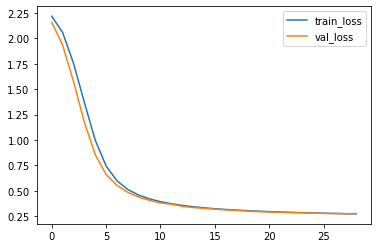

In [ ]:
plt.plot(loss,label='train_loss')
plt.plot(val_loss,label='val_loss')
plt.legend()

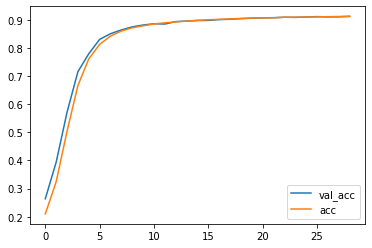

In [ ]:
plt.plot(val_acc,label='val_acc')
plt.plot(acc,label='acc')
plt.legend()

In [ ]:
model.save("model.h5")

In [ ]:
from keras.models import load_model
model = load_model("model.h5")

In [ ]:
import numpy as np

In [ ]:
def test(text):
  
  print(text)
  text = tfidf_vect.transform([text])
  text = svd.transform(text)
  pred = model.predict(text)
  label_index = np.argmax(np.squeeze(pred, axis = 0))
  print("Label : ------ ")
  print(encoder.inverse_transform([label_index])[0])

In [ ]:
y_pred = model.predict(X_test_tfidf_svd)

In [ ]:
y_pred = [encoder.inverse_transform([np.argmax(pred)])[0] for pred in y_pred]

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(Y_test, y_pred))  

                  precision    recall  f1-score   support

Chinh_tri_Xa_hoi       0.88      0.84      0.86      1899
        Doi_song       0.87      0.79      0.82       763
        Khoa_hoc       0.78      0.84      0.81       618
      Kinh_doanh       0.87      0.91      0.89      1151
       Phap_luat       0.92      0.90      0.91      1144
        Suc_khoe       0.92      0.93      0.93      1328
        The_gioi       0.91      0.95      0.93      1413
        The_thao       0.99      0.98      0.98      1772
         Van_hoa       0.94      0.94      0.94      1456
         Vi_tinh       0.93      0.95      0.94      1076

        accuracy                           0.91     12620
       macro avg       0.90      0.90      0.90     12620
    weighted avg       0.91      0.91      0.91     12620



In [ ]:
x = input("Enter text:")
test(x)

Enter text:cac
cac
Label : ------ 
Vi_tinh
